## Evaluating regression techniques for speaker characterization - Part I
### Laura Fernández Gallardo


#### Motivation

The ability to assess speakers' social and personality-related characteristics automatically is desired in multiple novel systems that aim at offering individualized services. Recent developments have led to speech assistants with excellent
natural language understanding and synthesis capabilities [1]. However, the characterization of individuals and their intentions
and behavior still needs to be improved in order to achieve even more human-like communications.

[My work](http://www.qu.tu-berlin.de/?id=lfernandez) examines user characterization from their voices, i.e. recognizing their traits (confidence, friendliness, competence, etc.) by the sound of their voices and manner of speaking. 

<p style="text-align: center;">Can we automatically recognize users' interpersonal traits by their voices?<p>

#### Speech material and features

I will employ the newly released [Nautilus Speaker Characterization (NSC) corpus](http://www.qu.tu-berlin.de/?id=nsc-corpus) [2]. The corpus contains clean conversational speech from 300 German speakers and labels of 34 interpersonal traits (likability, confidence, maturity, etc.) obtained by subjective listening.

These data is freely available for non-commercial research at the [CLARIN repository](hdl.handle.net/11022/1009-0000-0007-C05F-6).

As speech features I considered the extended Geneva Minimalistic Acoustic Parameter Set (eGeMAPS) for this initial exploratory analysis [3]. The [openSMILE toolkit](http://audeering.com/technology/opensmile/) was employed to extract this speech feature set. Frequency-, energy-, spectral, and temporal-related parameters are extracted from windowed speech. After smoothing over time with a symmetric 3-frame moving average, functionals such as mean, coefficient of variation, and percentiles are computed and included in the final set of 88 speech features.

This repository **does not contain speakers' sensible data**, complying with the NSC license. All speakers names were pseudonymised. There is no possibility to retrieve the original recorded speech from the provided material.


#### Scope

The goal of this project is to predict speakers' interpersonal traits based on the speech features mentioned above (functionals of F0, loudness, mfccs, jitter, etc.).

I will start by fitting regression models. Let is define the common RMSE (root-mean-square error) and the more robust to outliers MAPE (median absolute percentage) as the metrics for success:

\begin{equation}
RMSE = \sqrt{\frac{\sum_i(y_i-\hat{y}_i)^2}{n}}  
\end{equation}

\begin{equation}
MAPE = median(\left | \frac{y_i-\hat{y}_i}{y_i} \right |)
\end{equation}

where $y_i$ and $\hat{y_i}$ are the observed and the predicted values for the $i^{th}$ data point.

Possible applications of this research can be the adaptation of human-machine spoken dialog systems. The predicted speakers' traits can be strong indicators of their preferences and individual behavior, which could provide cues for dialog adaptation. Systems could dynamically respond by generating different dialog strategies or by synthesizing emotions or personality. Of course, more data apart from the controlled NSC corpus would be necessary for the validation of my results.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
# load numeric labels from subjective listening
ratings = pd.read_csv("SC_ratings.csv", sep = ';')

# load subjective questionnaire items and their translations

# load speech features from male and from female speakers
feats_m = pd.read_csv("eGeMAPSv01a_88_malespk.csv", sep = ',')
feats_f = pd.read_csv("eGeMAPSv01a_88_femalespk.csv", sep = ',')

In this exploratory analysis, let us look at:

* some ratings data summaries
* distribution of ratings for each trait
* aggregated numeric data labels
* feature distributions and collinearity

In [3]:
ratings.head()

,listener_pseudonym,listener_age,listener_gender,listener_language,sample_heard,speaker_ID,speaker_pseudonym,speaker_gender,speaker_age,unsympatisch,...,freundlich,maennlich,gehorsam,gleichgueltig,interessant,zynisch,aufgesetzt,intelligent,kindlich,bescheiden
0,Rater001,23,male,Deutsch,m016_beirut_stimulus.wav,16,beirut,male,21,0,...,97,91,42,25,78,58,33,82,73,64
1,Rater001,23,male,Deutsch,m023_malabo_stimulus.wav,23,malabo,male,30,78,...,65,100,60,72,58,56,15,76,12,63
2,Rater001,23,male,Deutsch,m044_stanley_stimulus.wav,44,stanley,male,27,19,...,38,90,39,26,13,70,87,23,34,44
3,Rater001,23,male,Deutsch,m071_jamestown_stimulus.wav,71,jamestown,male,30,5,...,96,100,73,6,93,19,8,87,8,91
4,Rater001,23,male,Deutsch,m076_prague_stimulus.wav,76,prague,male,23,91,...,37,36,75,67,16,20,89,10,94,41


In [4]:
len(ratings["speaker_ID"].unique()); # 300 speakers
len(ratings["listener_pseudonym"].unique()); # 114 listeners

Each stimulus file corresponds to a different speaker, and has been labeled by external raters on 34 interpersonal speaker characteristics on a scale from 0 to 100 using a slider. A semantic differential questionnaire was used (more details [here](http://www.qu.tu-berlin.de/?id=nsc-corpus))

As an example, let us explore the ratings distributions given to one of the speakers.

In [13]:
# Example of ratings given to one of the 300 speakers

ratings_beirut = ratings[ratings["speaker_pseudonym"]=="beirut"]
len(ratings_beirut["listener_pseudonym"].unique())  # 16 listeners provided ratings to this speaker   
ratings_beirut

,listener_pseudonym,listener_age,listener_gender,listener_language,sample_heard,speaker_ID,speaker_pseudonym,speaker_gender,speaker_age,unsympatisch,...,freundlich,maennlich,gehorsam,gleichgueltig,interessant,zynisch,aufgesetzt,intelligent,kindlich,bescheiden
0,Rater001,23,male,Deutsch,m016_beirut_stimulus.wav,16,beirut,male,21,0,...,97,91,42,25,78,58,33,82,73,64
161,Rater005,25,male,Deutsch,m016_beirut_stimulus.wav,16,beirut,male,21,11,...,96,100,99,21,86,20,88,97,67,98
445,Rater012,27,female,Chinesisch,m016_beirut_stimulus.wav,16,beirut,male,21,26,...,86,100,37,86,25,65,82,66,40,75
525,Rater014,22,male,Deutsch,m016_beirut_stimulus.wav,16,beirut,male,21,43,...,82,75,74,44,58,38,39,34,57,61
604,Rater016,25,male,Deutsch,m016_beirut_stimulus.wav,16,beirut,male,21,29,...,58,56,27,28,26,41,65,45,71,62
1044,Rater027,24,male,Deutsch,m016_beirut_stimulus.wav,16,beirut,male,21,40,...,63,93,67,60,71,38,32,72,38,64
1243,Rater032,21,male,Deutsch,m016_beirut_stimulus.wav,16,beirut,male,21,12,...,70,100,76,53,75,1,76,26,83,72
1442,Rater037,33,male,Deutsch,m016_beirut_stimulus.wav,16,beirut,male,21,60,...,41,100,40,45,44,59,41,43,26,39
2154,Rater055,25,male,Deutsch,m016_beirut_stimulus.wav,16,beirut,male,21,36,...,58,75,73,73,37,35,16,62,36,61
2437,Rater062,24,female,Polnisch,m016_beirut_stimulus.wav,16,beirut,male,21,28,...,91,97,44,67,68,31,17,74,38,39


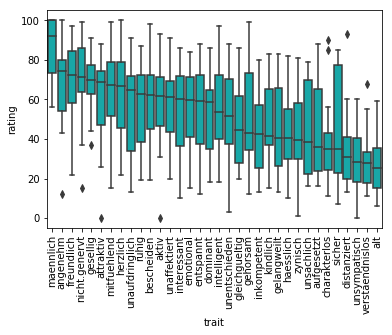

In [15]:
# sorting by columns median
ratings_beirut = ratings_beirut.reindex_axis(ratings_beirut.iloc[:,9:].median().sort_values(ascending=False).index, axis=1)
  
# extracting ratings to each interpersonal trait (reshaping for plot)
traits = list(ratings_beirut)
ratings_beirut_melt = pd.melt(ratings_beirut, id_vars=['listener_pseudonym'], value_vars=traits)
ratings_beirut_melt.columns = ['listener_pseudonym','trait','rating']

# create plot
plot_beirut = sns.boxplot(data = ratings_beirut_melt, x = "trait", y = "rating", color="c")
plot_beirut.set_xticklabels(traits,rotation=90);
plt.show()

I will consider the median of the group of raters as the true label for each trait. A better way to do this would be to apply some multi-rater modeling technique to be able to extract a better ground truth - hopefully removing some subjectivity. 

In [160]:
# just keep speaker ID and rating in the dataframe
ratings2 = pd.concat([ratings.iloc[:,[5,7]], ratings.iloc[:,9:]], axis = 1)

# aggregate ratings by median for each trait separately
ratings_agg = ratings2.groupby(['speaker_ID','speaker_gender']).agg('median')


In [164]:
ratings_agg.head()

,,unsympatisch,sicher,attraktiv,verstaendnislos,unentschieden,unaufdringlich,distanziert,gelangweilt,emotional,nicht.genervt,...,freundlich,maennlich,gehorsam,gleichgueltig,interessant,zynisch,aufgesetzt,intelligent,kindlich,bescheiden
speaker_ID,speaker_gender,,,,,,,,,,,,,,,,,,,,,
1,female,33.5,63.5,61.0,34.0,34.0,68.0,39.5,33.0,56.0,71.0,...,78.5,15.0,62.0,31.5,60.5,42.0,30.5,63.5,42.5,57.5
2,female,67.0,60.0,42.0,56.0,29.0,62.0,60.0,63.0,44.0,55.0,...,57.0,15.0,60.0,61.0,37.0,54.0,64.0,48.0,30.0,57.0
3,female,41.0,73.5,39.5,30.0,25.5,41.5,34.0,35.0,62.5,67.0,...,64.0,22.0,40.5,38.5,57.5,50.5,41.5,65.0,11.0,51.5
4,male,37.5,60.5,39.5,58.0,38.0,51.0,51.0,54.0,41.5,58.5,...,50.0,77.5,45.0,59.5,46.0,57.5,41.5,54.5,39.5,44.0
5,male,36.0,66.0,57.0,53.0,36.0,62.0,46.0,42.0,43.0,72.0,...,53.0,78.0,42.0,56.0,57.0,56.0,36.0,63.0,32.0,42.0


In [184]:
# save labels dataframe 

ratings_agg.to_csv("ratings_agg.csv")

For features:

* center and scale features of all data
* join males and females and add 1-hot encoded gender feature
* consider train/dev partitions (no test data, since we have too few instances)

Within each fold of the cross-validation:

* Center as scale ??
* Feature selection looking at importance measures
* Feature selection removing multicollinearity:

    1. Performing PLS (partial least squares) 
    2. Performing PCA (principal component analysis)
    3. Dropping features with high VIF (variance inflation factor) - to be calculated after train/dev/test 

In [187]:
feats_m.columns

Index(['sample_heard', 'F0semitoneFrom27.5Hz_sma3nz_amean',
       'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
       'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
       'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
       'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
       'F0semitoneFrom27.5Hz_sma3nz_pctlrange0.2',
       'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
       'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
       'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
       'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope', 'loudness_sma3_amean',
       'loudness_sma3_stddevNorm', 'loudness_sma3_percentile20.0',
       'loudness_sma3_percentile50.0', 'loudness_sma3_percentile80.0',
       'loudness_sma3_pctlrange0.2', 'loudness_sma3_meanRisingSlope',
       'loudness_sma3_stddevRisingSlope', 'loudness_sma3_meanFallingSlope',
       'loudness_sma3_stddevFallingSlope', 'spectralFlux_sma3_amean',
       'spectralFlux_sma3_stddevNorm', 'mfcc1_sma3_amean',
       'mfcc1_sma3_stdd

In [188]:
feats_m.describe()

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0.2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,slopeUV0.500_sma3nz_amean,slopeUV500.1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,...,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,26.403222,0.217966,23.102149,26.290208,29.416951,6.314802,301.405444,464.936512,173.860756,304.372706,...,-0.008394,0.008261,0.093598,2.913186,2.069913,0.216065,0.183660,0.271571,0.421506,-27.988421
std,2.244321,0.044559,2.333913,2.446944,2.585298,1.795572,134.959348,273.435616,98.301943,252.178868,...,0.011939,0.002252,0.028576,0.443000,0.290835,0.042786,0.040105,0.044672,0.055350,0.549652
min,20.369190,0.113135,15.787630,19.008480,22.374690,2.906771,66.365950,38.679040,42.065830,37.198150,...,-0.037122,0.001837,0.044194,2.101079,1.301048,0.125636,0.096586,0.169828,0.278952,-29.870780
25%,24.786558,0.188221,21.218930,24.507523,27.748027,5.046334,210.181300,271.482125,111.780425,130.056000,...,-0.016857,0.006638,0.074083,2.561641,1.881473,0.188633,0.154420,0.242538,0.389412,-28.256870
50%,26.208450,0.212369,23.370750,26.129820,29.248690,6.059022,279.248350,395.081450,149.919050,218.691900,...,-0.006812,0.008353,0.088153,2.815377,2.043272,0.212000,0.180269,0.266300,0.419523,-27.960730
75%,27.966462,0.246673,24.608948,27.954930,31.088712,7.376972,375.867600,665.108150,213.726650,373.549075,...,-0.000958,0.009915,0.107614,3.217171,2.224188,0.237312,0.208668,0.305417,0.457186,-27.737000
max,33.476950,0.331020,30.536680,33.647790,36.812130,12.595500,693.417700,1157.797000,759.916400,1379.039000,...,0.021897,0.015888,0.205118,4.529817,3.162737,0.397500,0.301186,0.393125,0.579329,-26.284370


In [223]:
# Standardize features for each gender spearately

# male speakers
scaler_m = StandardScaler()
scaler_m.fit(feats_m.iloc[:,1:])
feats_m_scaled = scaler_m.transform(feats_m.iloc[:,1:]) # numpy 126x88

# female speakers
scaler_f = StandardScaler()
scaler_f.fit(feats_f.iloc[:,1:])
feats_f_scaled = scaler_f.transform(feats_f.iloc[:,1:]) # numpy 174x88

In [224]:
# removing collinearity


(174, 88)

### What's next

In Part II:

* apply regression on each interpersonal trait from speech features
* examine the performance of different algorithms

#### References

[1] J. Masche and N.-T. Le, "A Review of Technologies for Conversational Systems," in Advances in Intelligent Systems and Computing, pp. 212–225. Springer, 2018.

[2] L. Fernández Gallardo and B. Weiss, "The Nautilus Speaker Characterization Corpus: Speech Recordings and Labels of Speaker Characteristics and Voice Descriptions," in International Conference on Language Resources and Evaluation (LREC), 2018.

[3] F. Eyben, K. R. Scherer, B. W. Schuller, J. Sundberg, E. André, C. Busso, L. Y. Devillers, J. Epps, P. Laukka, S. S. Narayanan, and K. P. Truong, "The Geneva Minimalistic Acoustic Parameter Set (GeMAPS) for Voice Research and Affective Computing," IEEE Transactions on Affective Computing, vol. 7, no. 2, pp. 190–202, 2016.